# Settings

In [1]:
plotpars = {'axes.labelsize': 18,
            'axes.linewidth': 1.,
            'figure.figsize': (7.,5.),
            'font.size': 12,
            'legend.frameon': True,
            'legend.framealpha': 0.85,
            'legend.edgecolor': 'black',
            'legend.loc': 'best',
            'legend.fontsize': 12,
            'mathtext.fontset': 'stixsans',
            'savefig.bbox': 'tight',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
           }

# Libraries

In [2]:
# usual libraries ----------------------------------------------------------------------------------------------------
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf
import astropy.constants as ct
import os
import time
import scipy.interpolate as sci
import ipywidgets        as widgets

In [3]:
# ppxf separately ----------------------------------------------------------------------------------------------------
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Data

In [4]:
data = pd.read_csv('../../Catalogue/Match07_smalldoubleclean_emlines.csv')

In [5]:
output_path = '../../LargeFilesResults/SEDFitting/ResultsRP'

In [6]:
uvup_data = data.loc[data['UV_CLASS_YI2011']=='UV_UPTURN']

In [7]:
target_sample = uvup_data[uvup_data['WHAN_CLASS']=='Retired/Passive']

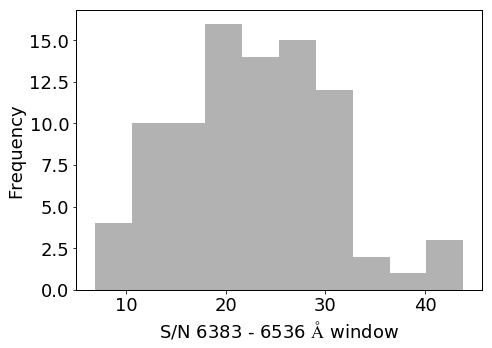

In [9]:
plt.hist(target_sample['SN'], bins=10, color='gray', alpha=0.6)
plt.xlabel(r"S/N 6383 - 6536 $\rm{\AA}$ window")
plt.ylabel(r"Frequency")
plt.rcParams.update(plotpars)
plt.tight_layout()
plt.savefig('../../LargeFilesResults/SEDFitting/ResultsRP/s2n_distribution.pdf')
plt.show()

# pPXF

In [ ]:
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
seds_path    = './../../../../GAMADR3_SPECTRA/DATABASE/'
light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])            # selecting the numerical values (must be in km/s)
gama_resol   = 1300.

In [ ]:
seds_list = []
for i in target_sample['SPECID']: seds_list.append(i+'.fit')

In [ ]:
bar = widgets.IntProgress(value=0, min=0, max=len(seds_list)+1, step=0.5, description='pPXF:', 
                          orientation='horizontal')
display(bar)

In [ ]:
palette      = ['#ef8a62','#f7f7f7','#67a9cf']
transparency = 0.8
lw           = 2.

In [ ]:
# Fit (V, sig, h3, h4) moments=4 for the stars; (V, sig) moments=2 for the two gas kinematic components
moments        = [4, 2, 2]
# degree         = -1        # Additive Legendre polynomial degrees
degree         = 10
mdegree        = 50        # Multiplicative Legendre polynomial degrees
regul_err      = 0.013     # Desired regularization error -- TODO: MUST CHECK WHY 0.013
tied_balmer    = True
limit_doublets = False
stellar_comp_w = [0]        # weight of the stellar component
balmer_comp_w  = [1]        # weight of the balmer emission lines
forbid_comp_w  = [2]        # weight of the forbidden lines
# wl_min         = 3540       # MILES RANGE MIN
# wl_max         = 7409       # MILES RANGE MAX
wl_min = 4350            # removing the bluest part of the spectra in order to mitigate noise effects
wl_max = 7409

In [ ]:
mean_age   = ['<logAge>']
mean_metal = ['<[M/H]>']
mass2light = ['MASS2LIGHT_R']
ids        = ['CATAID']
redshifts  = ['Z']

In [ ]:
for each_sed in range(len(seds_list)):
    
    # settings for the prgress bar widget above: does not influence in ppxf -----------------------------------------
    bar.value += each_sed/2.                                          # signal to increment the progress bar
    if each_sed<len(seds_list): 
        bar.bar_style = ""                                            # blue when in progress
    else: 
        bar.bar_style = "success"                                     # green when it finishes        
        
    # flux -----------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list[each_sed])          # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength -----------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini     # sed wavelength    
#     plot_sed(sed_wl, sed_flux, sed_err)
    
    # cleaning flux and wavelength trash -----------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                           # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]    
#     plot_sed(wavelength_temp, flux_temp, flux_temp_err)
    
    # limiting the spectrum regarding the wavelength range of the library --------------------------------------------
    wl_lib_idx = (wavelength_temp>wl_min) & (wavelength_temp<wl_max)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]    
#     plot_sed(wavelength, flux, flux_err)    
    
    # other important parameters -------------------------------------------------------------------------------------
    redshift  = sed_header['Z']
    cataid    = sed_header['CATAID']
    fwhm_gama = 2.
#     print(wavelength, gama_resol)
#     fwhm_gama = wavelength*gama_resol
#     print(len(fwhm_gama))
    
#     # ppxf ---------------------------------------------------------------------------------------------------------
    vel_scale  = light_speed*np.log(wavelength[1]/wavelength[0])      # velocity scale - Eq.8 Capellari 2017
    
#     ### setup templates --------------------------------------------------------------------------------------------
#     #### stellar pops ----------------------------------------------------------------------------------------------
    miles = lib.miles(miles_lib, vel_scale, fwhm_gama)
#     print(miles)
#     print("All ok here %s" %cataid)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    reg_dim            = miles.templates.shape[1:]
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]
    
    #### gas templates -----------------------------------------------------------------------------------------------
    wl_range_galaxy = np.array([np.min(wavelength), np.max(wavelength)])/(1 + redshift)
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, wl_range_galaxy, fwhm_gama, 
                                                              tie_balmer=tied_balmer, limit_doublets=limit_doublets)
    number_of_templates = stellar_templates.shape[1]
    number_of_forbidden = np.sum(["[" in a for a in gas_names])                      # forbidden lines contain "[*]"
    number_of_balmer    = len(gas_names) - number_of_forbidden
        
    component = (stellar_comp_w*number_of_templates)+(balmer_comp_w*number_of_balmer)+(forbid_comp_w
                                                                                       *number_of_forbidden)
        
    gas_component = np.array(component) > 0       # gas_component=True for gas templates
    start3        = [start, start, start]         # adopt the same starting value for the 3 components
    gas_reddening = 0 if tied_balmer else None    # If the Balmer lines are tied one should allow for gas reddening.
    
    
    #### all templates -----------------------------------------------------------------------------------------------
    all_templates = np.column_stack([stellar_templates, gas_templates])
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) -------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error ------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wavelength_rebin)
    
    ### final galaxy spectrum and its error to be analysed -----------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)               # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)       # idem
    
#     plot_sed(wavelength_rebin, galaxy, noise)    
    
    ### SED FITTING WITH PPXF ----------------------------------------------------------------------------------------
    start_time = time.clock()
    sed_fit = ppxf(templates=all_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start3, plot=False, 
                   lam=wavelength_rebin, moments=moments, degree=degree, mdegree=mdegree, regul=1./regul_err, 
                   reg_dim=reg_dim, vsyst=dv, clean=False, component=component, gas_component=gas_component,
                   gas_reddening=gas_reddening)
    end_time = time.clock()
    
    ## output parameters -- most of them will become a dataframe at the end of the script  
    residues = (galaxy-sed_fit.bestfit)
    
    stellar_weights = sed_fit.weights[~gas_component]                         # Exclude weights of the gas templates
    stellar_weights = stellar_weights.reshape(reg_dim)/stellar_weights.sum()  # Normalized
    
    velocity = sed_fit.sol[0][0]
    sigma    = sed_fit.sol[0][1]
    
    mean_age.append(miles.mean_age_metal(stellar_weights)[0])
    mean_metal.append(miles.mean_age_metal(stellar_weights)[1])
    mass2light.append(miles.mass_to_light(stellar_weights, band="r"))
    ids.append(cataid)
    redshifts.append(redshift)
       
    print(r"Current $\chi^2$: %.4f" % (sed_fit.chi2))
    print('Elapsed time in PPXF: %.2f [min]' % ((end_time-start_time)/60))
    
    ### Saving fit results -------------------------------------------------------------------------------------------
    output = {}
    output['wavelength'] = wavelength_rebin
    output['flux']       = sed_fit.galaxy
    output['best_fit']   = sed_fit.bestfit
    
    output_df = pd.DataFrame(output)
    output_df.to_csv(os.path.join(output_path, 'fit_'+str(cataid)+'_d'+str(degree)+'_m'+str(mdegree)+'_'+str(wl_min)
                                  +'.csv'), index=False)

    ### Saving plots -------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(12,8))
    
    #### plot01 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.title("Object %s" % (cataid))
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    
    #### plot02 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,2)
    miles.plot(stellar_weights)
    
    #### plot03 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,3)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    plt.ylim([-1,1])
    
    #### plot04 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,4)
    plt.text(0.1, 0.5, "Object:{:s} \n mdegree = {:d} \n regul_err = {:.4f}\n S2N(runz) = {:.4f}"
             .format(sed_header['SPECID'], mdegree, regul_err, sed_header['SN']), fontsize=13)
    plt.text(0.1, 0.0, " \n $\chi^2$ ppxf = {:.4f} \n velocity = {:.4f} \n $\sigma$ = {:.4f}"
             .format(sed_fit.chi2, velocity, sigma), fontsize=13)
    plt.axis('off') 
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'gal_'+str(cataid)+'_d'+str(degree)+'_m'+str(mdegree)+'_'+str(wl_min)+'.png'))
    plt.show()